### 2Dの対応点から2Dの変換パラメータ（3つ)を算出する。

In [52]:
%matplotlib inline
import cv2
import numpy as np
import random
import math
import matplotlib.pyplot as plt # matplotlibの描画系

In [53]:
#同次座標系に関する関数
def makeHomogeneous(vector):
    rows,cols = vector.shape[:2]
    ones = [np.ones(cols)]
    return np.r_[vector, ones]
    
def delHomogeneous(vector):
    rows,cols = vector.shape[:2]
    val = vector[:rows-1]
    dim = vector[rows-1:]
    return val / dim

#二次元回転行列生成に関する関数
def generateRotationMatrix(r): 
    Rz = np.array(
            [[np.cos(r), np.sin(r)],
            [-np.sin(r), np.cos(r)]])
    return Rz

def generateTransMatrix(t, r):
    R = generateRotationMatrix(r)
    transMatrix = np.eye(3,3)
    for y in range(0,2):
        for x in range(0,2):
            transMatrix[y, x] = R[y, x]
        transMatrix[y, 2] = t[y]
    return transMatrix

In [88]:
#データ生成
box_size_x = 10
box_size_y = 5
step = 10

obj = np.empty((2,0), float)
for i in range(0, box_size_x):
    x = i * step
    y = 0
    vec = np.array([x, y])
    obj = np.hstack([np.c_[obj], np.c_[vec]])
    y = box_size_y * step
    vec = np.array([x, y])
    obj = np.hstack([np.c_[obj], np.c_[vec]])

for j in range(0, box_size_y):
    x = 0
    y = j * step
    vec = np.array([x, y])
    obj = np.hstack([np.c_[obj], np.c_[vec]])
    x = box_size_x * step
    vec = np.array([x, y])
    obj = np.hstack([np.c_[obj], np.c_[vec]])

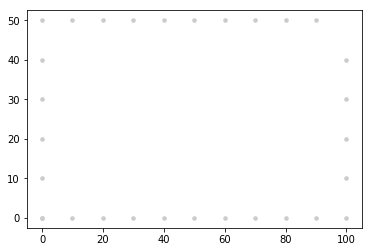

In [89]:
# グラフ作成
fig = plt.figure()

# グラフ描画
plt.plot(obj[0], obj[1], "o", color="#cccccc", ms=4, mew=0.5)
plt.show()

In [90]:
#二次元姿勢変換データ作成
t = np.array([20, 0])
p = np.array([np.pi / 16])
dM = generateTransMatrix(t, p)
print (dM)

[[  0.98078528   0.19509032  20.        ]
 [ -0.19509032   0.98078528   0.        ]
 [  0.           0.           1.        ]]


In [104]:
#観測データ作成
#座標変換
obj_h = makeHomogeneous(obj)
obs_h = dM.dot(obj_h)
obs = delHomogeneous(obs_h)

#ノイズ付加
obs += np.random.randn(obs.shape[0],obs.shape[1])

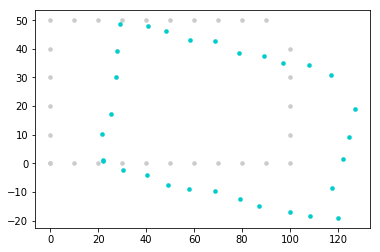

In [92]:
# グラフ作成
fig = plt.figure()

# グラフ描画
plt.plot(obj[0], obj[1], "o", color="#cccccc", ms=4, mew=0.5)
plt.plot(obs[0], obs[1], "o", color="#00cccc", ms=4, mew=0.5)
plt.show()

### ヤコビアン計算

$X_0 = (x_0, y_0)$を$X_1 = (x_1, y_1)$に変換するとき、  
$$
e = \frac{1}{2} \Sigma (X_0 - X_1)^2
$$
を最小化するような幾何変換$ \Delta R, \Delta t$を最小二乗法により算出する。  
変換式は
$$ 
\begin{eqnarray}
  \left(
    \begin{array}{c}
      x_{1} \\
      y_{1}
    \end{array}
  \right)
  &=&
  \Delta R
  \left(
    \begin{array}{c}
      x_{0}\\
      y_{0}
    \end{array}
  \right)
  +
  \Delta t
  \\
  &=&
  \left(
    \begin{array}{c}
      0 & - \Delta \theta \\
      \Delta \theta & 0
    \end{array}
  \right)
  \left(
    \begin{array}{c}
      x_{0}\\
      y_{0}
    \end{array}
  \right)
  +
  \left(
    \begin{array}{c}
      \Delta t_{x}\\
      \Delta t_{y}
    \end{array}
  \right)
  \end{eqnarray}
$$ 

このとき、ヤコビ行列$J$は
$$ 
\begin{eqnarray}
  J
  &=&
  \left(
    \begin{array}{c,c,c}
      \frac{\delta x}{\delta \theta} &
      \frac{\delta x}{\delta t_{x}} &
      \frac{\delta x}{\delta t_{y}} \\
      \frac{\delta y}{\delta \theta} &
      \frac{\delta y}{\delta t_{x}} &
      \frac{\delta y}{\delta t_{y}}
    \end{array}
  \right)
  \\
  &=&
  \left(
    \begin{array}{c,c,c}
    1 & 0 & - y_0\\
    0 & 1 & x_0
    \end{array}
  \right)
  \end{eqnarray}
$$ 
となる。  
ところで、各パラメータによる微分が0(極値)となる条件は$\Delta E = 0$である。
つまり、
$$
J^tJ \Delta = J^Te 
$$
$$
\Delta = (J^tJ)^{-1}J^Te 
$$
である。これを解く各種solverは多数ライブラリが存在しており、一般的には$J^tJ$と$J^Te$を引数として取る。そこで、繰り返し計算により$\Delta R, \Delta t$を計算し$J^tJ$と$J^Te$を更新し、徐々に誤差を小さくする。

In [93]:
#ヤコビアン計算
def calcJacob(obj, obs, deltaPose, JtJ, JtE):
    if obj.shape[1] != obs.shape[1]:
        print ("ERROR data size is not the same!")
    #座標変換
    obj_h = makeHomogeneous(obj)
    obs_h = deltaPose.dot(obj_h)
    est = delHomogeneous(obs_h)
    
    for (p, q) in zip(est.transpose(), obs.transpose()):
        x = p[0]
        y = p[1]
        ex = q[0] - p[0]
        ey = q[1] - p[1]
        
        JtJ[0,0] += 1.0
        JtJ[0,2] += -y
        JtJ[1,1] += 1.0
        JtJ[1,2] += x
        JtJ[2,2] += x * x + y * y
        
        JtE[0,0] += ex
        JtE[1,0] += ey
        JtE[2,0] += -ex * y + x * ey
        
    #fill
    JtJ[1,0] = JtJ[0,1]
    JtJ[2,0] = JtJ[0,2]
    JtJ[2,1] = JtJ[1,2]

In [94]:
def calcPose2D(obj, obs, deltaPose):

    #ヤコビ行列生成
    JtJ = np.zeros((3,3))
    JtE = np.zeros((3,1))
    calcJacob(obj, obs, deltaPose, JtJ, JtE)
    
    #solve
    x = np.linalg.solve(JtJ, JtE)
    t = x[0:2]
    omega = x[2]

    #補正量計算
    angle = math.sqrt(omega*omega)
    dR = np.eye(3,3)
    if angle < 1.0e-12:
        print ("a")
    else:
        dR[0,1] = -omega
        dR[1,0] = omega
    
    #行列生成
    transMatrix = np.eye(3,3)
    for y in range(0,2):
        for x in range(0,2):
            transMatrix[y, x] = dR[y, x]
        transMatrix[y, 2] = t[y]
    return transMatrix.dot(deltaPose)

In [101]:
estPose = np.eye(3,3)
#適当に回す。
for i in range(5):
    estPose = calcPose2D(obj, obs, estPose)
    print (estPose)

[[  1.           0.19397421  19.21233554]
 [ -0.19397421   1.          -0.58004095]
 [  0.           0.           1.        ]]
[[  0.99924301   0.19787673  19.15660292]
 [ -0.19787673   0.99924301  -0.38026052]
 [  0.           0.           1.        ]]
[[  0.99922748   0.19795518  19.15549736]
 [ -0.19795518   0.99922748  -0.37623688]
 [  0.           0.           1.        ]]
[[  0.99922716   0.19795676  19.15547512]
 [ -0.19795676   0.99922716  -0.37615593]
 [  0.           0.           1.        ]]
[[  0.99922716   0.19795679  19.15547467]
 [ -0.19795679   0.99922716  -0.3761543 ]
 [  0.           0.           1.        ]]


In [102]:
#座標変換
obj_h = makeHomogeneous(obj)
est_h = estPose.dot(obj_h)
est = delHomogeneous(est_h)

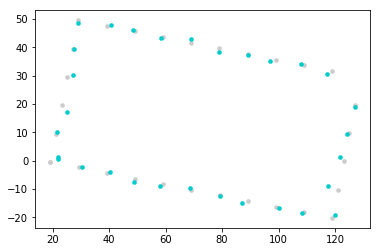

In [103]:
# グラフ作成
fig = plt.figure()

# グラフ描画
plt.plot(est[0], est[1], "o", color="#cccccc", ms=4, mew=0.5)
plt.plot(obs[0], obs[1], "o", color="#00cccc", ms=4, mew=0.5)
plt.show()